# Noisy excitation transport

In this example, we will look at the energy transport in a one-dimensional chain of atoms, where only the first atom is driven.
The excitation can then move from one atom to another via position-dependent dipolar interactions between nearest neighbors.

The Hamiltonian of this system reads

```math
H = -\Delta \sum_j \sigma_j^{ee} + \Omega\left(\sigma_1^{eg} + \sigma_1^{ge}\right) + \sum_{j=1}^{N-1}J(x_i,x_j)\left(\sigma_j^{eg}\sigma_{j+1}^{ge} + \sigma_j^{ge}\sigma_{j+1}^{eg}\right).
```


The first term describes the energy of the excited atomic state in the rotating frame of the driving laser with the detuning $\Delta$.
The second term describes the driving of the first atom with a laser with a Rabi frequency $\Omega$.
Finally, the interactions between nearest neighbors are included with the position-dependent interaction

```math
J(x_i,x_j) = \frac{J_0}{|x_i - x_j|^3},
```

where $J_0$ is the strength of the interaction at unit distance.
The positions of the atoms $x_i$ are in units of the transition wavelength.
Furthermore, each atom is subject to spontaneous emission at a rate $\gamma$ with the collapse operator $\sigma_j^{ge}$.

We will start by simulating the system as described above.
Specifically, we compute the efficiency of the excitation transport by looking at the excited state population of the atom at the end of the chain opposite to the driven atom.
Finally, we show how one can generalize the system to include random fluctuations in the atomic position.
We can then investigate the effect of the positional noise on the efficiency of the energy transport.

As always, we start by loading the packages we use and some basic definitions.

In [1]:
using QuantumCumulants
using ModelingToolkit, OrdinaryDiffEq
using Plots


# Hilbert space for N atoms
N = 10
h = ⊗([NLevelSpace(Symbol(:atom, i), (:g,:e)) for i=1:N]...)

# Operators
σ(i,j,k) = Transition(h,Symbol(:σ_,k),i,j,k)

# Define the symbolic parameters and the interaction
@cnumbers Ω γ w Δ J0
x = cnumbers(join(["x_$i" for i=1:N], " "))
J(xᵢ,xⱼ) = J0 / abs(xᵢ - xⱼ)^3

# Specify the Hamiltonian and the collapse operators
H = -Δ*sum(σ(:e,:e,k) for k=1:N) + Ω*(σ(:e,:g,1) + σ(:g,:e,1)) +
    sum(J(x[k],x[k+1])*(σ(:e,:g,k)*σ(:g,:e,k+1) + σ(:g,:e,k)*σ(:e,:g,k+1)) for k=1:N-1)

c_ops = [σ(:g,:e,k) for k=1:N]
nothing #hide

The above definitions are all we need to derive the set of equations.
Here, we will include terms up to second order.
Note, that in order to include noise, we will not need to make any adaptions on a symbolic level.
Rather, we only need to derive the equations once and substitute the noisy positions accordingly when performing the numerical solutions.

In [2]:
# Derive the equations to second order
eqs = meanfield(σ(:g,:e,1),H,c_ops;rates=[γ for i=1:N],order=2)
complete!(eqs)  # complete the set

# Generate the ODESystem
@named sys = ODESystem(eqs)
nothing #hide

Once we have our set of equations and converted it to an `ODESystem` we are ready to solve for the dynamics.
First, let's have a look at the excitation transport for perfectly positioned atoms.
We assume an equidistant chain, were neighboring atoms are separated by a distance $d$.

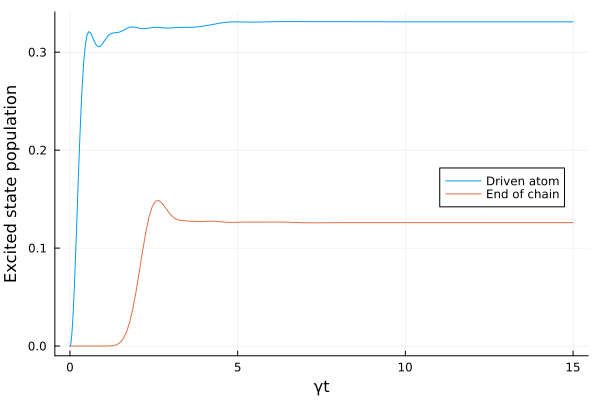

In [3]:
# Define parameters without noise
d = 0.75
x0 = [d*(k-1) for k=1:N]
ps = [γ; Δ; Ω; J0; x...]
p0 = [1.0; 0.0im; 2.0; 1.25; x0;]
p = ps.=>p0
#p = [γ => 1.0; Δ => 0.0; Ω => 2.0; J0 => 1.25; x .=> x0;]

# Create ODEProblem
u0 = zeros(ComplexF64, length(eqs))  # initial state -- all atoms in the ground state
prob = ODEProblem(sys,u0,(0.0,15.0),p)

# Solve
sol = solve(prob,RK4())

# Plot
graph = plot(sol.t, real.(sol[σ(:e,:e,1)]), label="Driven atom",
            xlabel="γt", ylabel="Excited state population")
plot!(graph, sol.t, real.(sol[σ(:e,:e,N)]), label="End of chain", leg=1)

As you can see, the excitation transport is reasonably efficient, resulting in an excited state population at the end of the chain well above 10%.

Now, we will introduce some noise in the atomic positions.
In order to do so, we make use of the convenient [ensemble simulation feature](https://diffeq.sciml.ai/stable/features/ensemble/) from the [OrdinaryDiffEq](https://diffeq.sciml.ai/stable/) library.
For each trajectory, we recreate the original `ODEProblem` with a new set of atomic positions.
We assume that each atom is located around the same point as before in the equidistant chain.
However, we account for imperfect positioning in that the actual position of each atom is randomly modified.
The strength of these position fluctuations is given by a parameter $s$, and the random fluctuations are sampled from a Gaussian distribution.

Each trajectory we simulate can be thought of as one realization of an experiment, where the atoms are trapped with imperfect accuracy.

In the following, we define the function that sets up the new `ODEProblem` for a realization and solve a specified number of trajectories.

In [4]:
s = d/30  # strength of fluctuations
function prob_func(prob,i,repeat)
    # Define the new set of parameters
    x_ = x0 .+ s.*randn(N)
    p_ = [γ => 1.0; Δ => 0.0; Ω => 2.0; J0 => 1.25; x .=> x_;]
    # Return new ODEProblem
    return ODEProblem(sys,u0,(0.0,15.0),p_)
end

trajectories = 20
eprob = EnsembleProblem(prob,prob_func=prob_func)
sim = solve(eprob,RK4(),trajectories=trajectories)
nothing #hide

Finally, we average over the results and compare them against the results from before, where there was no noise in the atomic positioning.

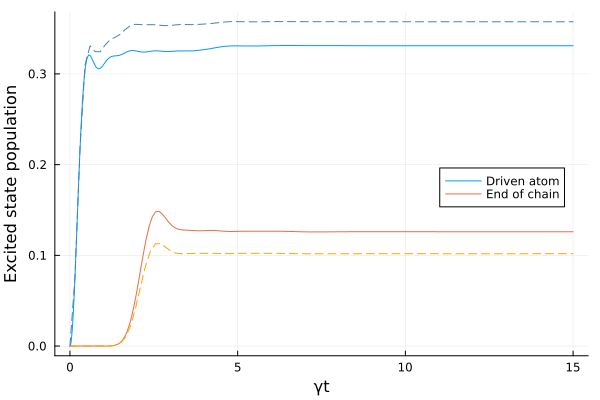

In [5]:
# Average resulting excitations
tspan = range(0.0, sol.t[end], length=101)
pops_avg = zeros(length(tspan), N)
for i=1:N, j=1:trajectories
    sol_ = sim.u[j].(tspan)  # interpolate solution
    p_idx = findfirst(isequal(average(σ(:e,:e,i))), unknowns(eqs))
    pop = [u[p_idx] for u ∈ sol_]
    @. pops_avg[:,i] += pop / trajectories
end

plot!(graph, tspan, pops_avg[:,1], color=:steelblue, ls=:dash, label=nothing)
plot!(graph, tspan, pops_avg[:,N], color=:orange, ls=:dash, label=nothing)


In the above graph, the solid lines are the ones from before, where we did not include any position fluctuations.
The dashed lines with the corresponding colors show the results when averaging over many noisy realizations.

As we can see, more of the excited state population remains in the driven atom at the beginning of the chain.
The efficiency of the transport is somewhat reduced and only approximately 10% excited state population are reached in the atom at the other end.

We can also plot the results for each trajectory on top of the average.
Let's look at each trajectory of the excited state population of the atom at the end of the chain.

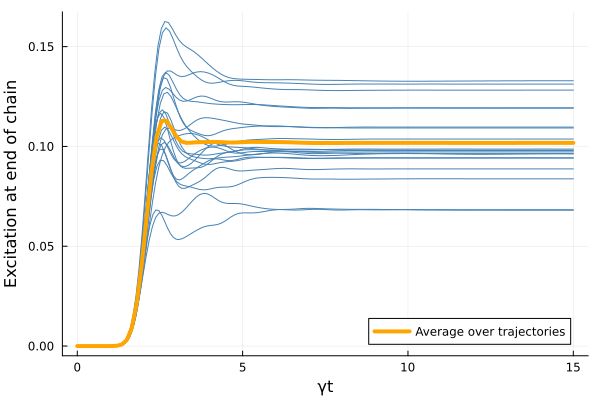

In [6]:
graph2 = plot(xlabel="γt", ylabel="Excitation at end of chain")
for i=1:trajectories
    plot!(graph2, sim.u[i].t, real.(sim.u[i][σ(:e,:e,N)]), color=:steelblue, label=nothing)
end
plot!(graph2, tspan, pops_avg[:,N], lw=4, label="Average over trajectories", color=:orange)


As you can see, in some realizations the transport is almost not hindered at all.
On average, however, the transport efficiency is reduced quite a bit.